In [1]:
import numpy as np
import gym
from gym import spaces

class MultiArmedBanditEnv(gym.Env):
    def __init__(self, n_arms=10):
        super(MultiArmedBanditEnv, self).__init__()
        self.n_arms = n_arms
        self.action_space = spaces.Discrete(n_arms)  # Number of arms
        self.observation_space = spaces.Discrete(1)  # No real state
        self.true_values = np.random.normal(0, 1, n_arms)  # True mean reward for each arm

    def reset(self):
        return 0  # Observation doesn't matter here

    def step(self, action):
        # Reward is sampled from the true value of the selected arm
        reward = np.random.normal(self.true_values[action], 1)
        done = False  # Multi-Armed Bandit is non-episodic
        return 0, reward, done, {}

    def render(self, mode="human"):
        print("True values:", self.true_values)

# Initialize environment
env = MultiArmedBanditEnv(n_arms=10)
env.render()


True values: [-0.0631635  -0.68209085 -0.90946722  0.66240787  0.66187799 -0.9335268
  1.48872899 -1.88966334 -2.54797786 -0.05392242]


In [2]:
def epsilon_greedy_agent(env, num_steps, epsilon=0.1):
    Q = np.zeros(env.n_arms)  # Action-value estimates
    N = np.zeros(env.n_arms)  # Action counts
    rewards = []

    for _ in range(num_steps):
        if np.random.rand() < epsilon:
            action = np.random.choice(env.n_arms)  # Exploration
        else:
            action = np.argmax(Q)  # Exploitation

        _, reward, _, _ = env.step(action)
        rewards.append(reward)

        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]

    return np.cumsum(rewards)  # Cumulative rewards over time


In [3]:
def ucb_agent(env, num_steps, c=1.0):
    Q = np.zeros(env.n_arms)  # Action-value estimates
    N = np.zeros(env.n_arms)  # Action counts
    rewards = []
    t = 0

    for _ in range(num_steps):
        if t < env.n_arms:  # Ensure each arm is pulled at least once
            action = t
        else:
            confidence_bounds = Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5))  # Avoid division by zero
            action = np.argmax(confidence_bounds)

        _, reward, _, _ = env.step(action)
        rewards.append(reward)

        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        t += 1

    return np.cumsum(rewards)  # Cumulative rewards over time


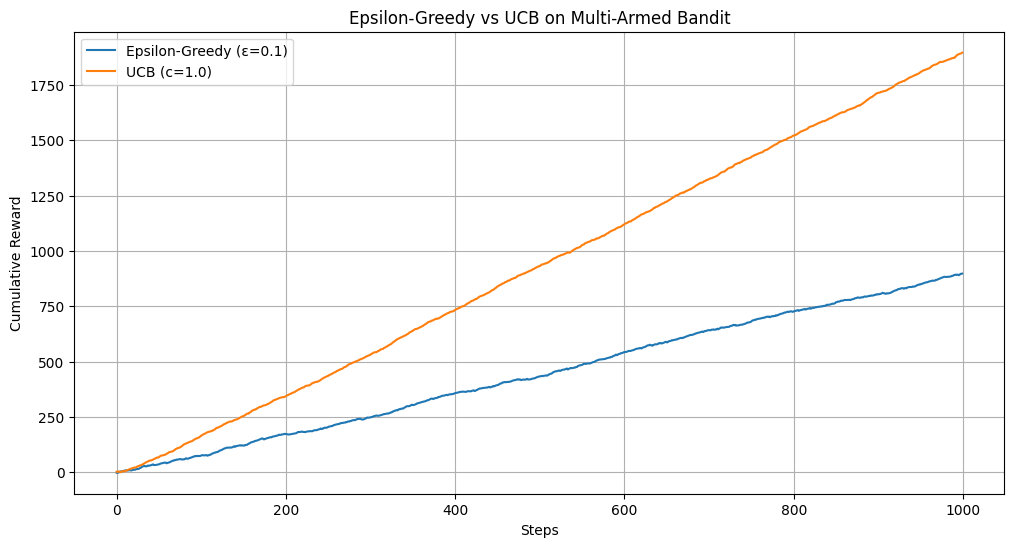

In [4]:
import matplotlib.pyplot as plt

# Parameters
num_steps = 1000
epsilon = 0.1
c = 1.0

# Train agents
env = MultiArmedBanditEnv(n_arms=10)
eg_rewards = epsilon_greedy_agent(env, num_steps, epsilon)
env = MultiArmedBanditEnv(n_arms=10)  # Reinitialize environment for fairness
ucb_rewards = ucb_agent(env, num_steps, c)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(eg_rewards, label=f"Epsilon-Greedy (ε={epsilon})")
plt.plot(ucb_rewards, label=f"UCB (c={c})")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.title("Epsilon-Greedy vs UCB on Multi-Armed Bandit")
plt.legend()
plt.grid()
plt.show()
